In [1]:
from ast import Lambda
from audioop import reverse
from cProfile import label
from ctypes import util
from email import header
from itertools import count
from platform import node
import this
import pandas as pd 
import tabulate as tb
from typing import Counter, List
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import networkx as nx 
import domain
import statistics, math
import igraph
from networkx.algorithms import bipartite as bp
from networkx.algorithms import community as nxcm
import scipy.stats as stats
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
from prefixspan import PrefixSpan
import functools
from scipy.stats import pointbiserialr

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
tactics : List['domain.Tactic'] = []
techniques : List['domain.Technique'] = []
procedures  : List['domain.Procedure'] = []
groups  : List['domain.Group'] = []
softwares  : List['domain.Software'] = []
cocTTPs : List[List['domain.Technique']] = []

In [3]:
def initializeTactics(tactics : List['domain.Tactic']) -> None:
    dfTactic = pd.read_excel('ttps.xlsx', sheet_name='tactic',engine="openpyxl")
    for row in dfTactic.itertuples():
        tactic = domain.Tactic(row.tacticId, row.tacticName)
        
        if row.tacticId == 'TA0043' : tactic.sequence = 1
        if row.tacticId == 'TA0042' : tactic.sequence = 2
        if row.tacticId == 'TA0001' : tactic.sequence = 3
        if row.tacticId == 'TA0002' : tactic.sequence = 4
        if row.tacticId == 'TA0003' : tactic.sequence = 5
        if row.tacticId == 'TA0004' : tactic.sequence = 6
        if row.tacticId == 'TA0005' : tactic.sequence = 7
        if row.tacticId == 'TA0006' : tactic.sequence = 8
        if row.tacticId == 'TA0007' : tactic.sequence = 9
        if row.tacticId == 'TA0008' : tactic.sequence = 10
        if row.tacticId == 'TA0009' : tactic.sequence = 11
        if row.tacticId == 'TA0011' : tactic.sequence = 12
        if row.tacticId == 'TA0010' : tactic.sequence = 13
        if row.tacticId == 'TA0040' : tactic.sequence = 14
        
        
        tactics.append(tactic)


In [4]:
def initializeTechniques(techniques : List['domain.Technique']) -> None:
    dfTechnique = pd.read_excel('ttps.xlsx', sheet_name='technique',engine="openpyxl")
    for row in dfTechnique.itertuples():
        ifAny = [x for x in techniques if x.id == row.techniqueId]
        if len(ifAny) == 0:
            technique = domain.Technique(row.techniqueId, row.techniqueName)
            techniques.append(technique)

In [5]:
def initializeTacticTechniqueMapping(tactics : List['domain.Tactic'], techniques : List['domain.Technique']) -> None:
    dfTechnique = pd.read_excel('ttps.xlsx', sheet_name='technique',engine="openpyxl")
    for row in dfTechnique.itertuples():
        technique = [x for x in techniques if x.id == row.techniqueId][0]
        tactic = [x for x in tactics if x.id == row.tactics][0]
        if tactic not in technique.tactics: technique.tactics.append(tactic)
        if technique not in tactic.techniques: tactic.techniques.append(technique)

In [6]:
def initializeGroups(groups : List['domain.Group'], techniques : List['domain.Technique']) -> None:
    dfGroups = pd.read_excel('ransomware_technique.xlsx', sheet_name='ttps',engine="openpyxl")
    dfGroups = dfGroups[['sourceId', 'targetId']]
    dfGroups['targetId'] = dfGroups['targetId'].apply(lambda v : v[0:5])
    dfGroups = dfGroups.drop_duplicates()
    dfg = dfGroups.groupby(['sourceId'])
    for name, group in dfg:
        g = domain.Group(name)
        for row in group.itertuples():
            ttp = [x for x in techniques if x.id == row.targetId][0]
            if ttp not in g.techniques: 
                g.techniques.append(ttp)
        groups.append(g)


In [7]:
def buildDataSchema(tactics : List['domain.Tactic'], techniques : List['domain.Technique'], groups : List['domain.Group'], ) -> None:
    initializeTactics(tactics)
    initializeTechniques(techniques)
    initializeTacticTechniqueMapping(tactics, techniques)
    initializeGroups(groups, techniques)
    return

In [8]:
buildDataSchema(tactics, techniques, groups)

In [9]:
def initializeCocGraph(groupsList : List['domain.Group'], softwareList : List['domain.Software'], cocTTPs : List[List['domain.Technique']], techniques : List['domain.Technique'], tactics : List['domain.Tactic'], min_cooccurring_technique = 3, min_pct_cooccurrence = 5) -> nx.Graph:
    allTechniques = []

    for g in groupsList:
        for te in g.techniques:
            allTechniques.append(te)

    allTechniques = list( set(allTechniques) )

    for s in softwareList:
        for te in s.techniques:
            allTechniques.append(te)

    allTechniques = list( set(allTechniques) )
    allTechniques.sort(key=lambda t : t.id)
    
    cocTTPs.extend([g.techniques for g in groupsList if len(g.techniques) >= min_cooccurring_technique])
    cocTTPs.extend([s.techniques for s in softwareList if len(s.techniques) >= min_cooccurring_technique])
    ttpsTuples = []

    for ttp1 in allTechniques:
        for ttp2 in allTechniques:
            count = 0
            for item in cocTTPs:
                if ttp1 in item and ttp2 in item and ttp1 != ttp2:
                    count += 1
            if (ttp1, ttp2, count) not in ttpsTuples and (ttp2, ttp1, count) not in ttpsTuples and ttp1 != ttp2 and count > len(cocTTPs)*min_pct_cooccurrence/100:
                ttpsTuples.append((ttp1, ttp2, count))
                

    ttpsTuples.sort(key= lambda i : i[2], reverse=True)

    graph = nx.Graph()
    graph.add_nodes_from([x.id for x in allTechniques])
    for node in graph.nodes:
        graph.nodes[node]['tactic'] = next( (x.tactics[0].id for x in techniques if x.id == node) )
        te = next( (x for x in techniques if x.id == node) )

        graph.nodes[node]['frequency'] = len([x for x in cocTTPs if te in x])

    for item in ttpsTuples:
        graph.add_edge(item[0].id, item[1].id, count = item[2], distance = ttpsTuples[0][2] + 1 - item[2])
    
    return graph

In [10]:
cocGraph : nx.Graph = initializeCocGraph(groups, softwares, cocTTPs, techniques, tactics)

In [11]:
def findTopTenTechniques(techniques, cocTTPs):
    techniquesSortedBySupport = []
    for te in techniques:
        sum = 0
        for coc in cocTTPs:
            if te in coc: 
                sum += 1
        techniquesSortedBySupport.append((te, sum))

    techniquesSortedBySupport.sort(key = lambda v : v[1], reverse=True)

    idx = 0
    for item in techniquesSortedBySupport[0:20]:
        idx += 1
        print(f"[{idx}] {item[0].id}: {item[0].name} @ {item[0].tactics[0].id}: {item[0].tactics[0].name} ==> {item[1]/len(cocTTPs)}")
    return

In [14]:
findTopTenTechniques(techniques, cocTTPs)

[1] T1486: Data Encrypted for TA0040 @ TA0040: Impact ==> 0.8151260504201681
[2] T1059: Command and Scripting Interpreter @ TA0002: Execution ==> 0.6974789915966386
[3] T1027: Obfuscated Files or Information @ TA0005: Defense Evasion ==> 0.47058823529411764
[4] T1083: File and Directory TA0007 @ TA0007: Discovery ==> 0.44537815126050423
[5] T1490: Inhibit System Recovery @ TA0040: Impact ==> 0.4369747899159664
[6] T1082: System Information TA0007 @ TA0007: Discovery ==> 0.40336134453781514
[7] T1562: Impair Defenses @ TA0005: Defense Evasion ==> 0.37815126050420167
[8] T1021: Remote Services @ TA0008: Lateral Movement ==> 0.37815126050420167
[9] T1055: Process Injection @ TA0005: Defense Evasion ==> 0.3025210084033613
[10] T1566: Phishing @ TA0001: Initial Access ==> 0.2773109243697479
[11] T1204: User TA0002 @ TA0002: Execution ==> 0.2605042016806723
[12] T1112: Modify Registry @ TA0005: Defense Evasion ==> 0.24369747899159663
[13] T1489: Service Stop @ TA0040: Impact ==> 0.2436974789

In [15]:
def findTopTactics(techniques, tactics, cocTTPs):
    techniquesSortedBySupport = []
    for te in techniques:
        sum = 0
        for coc in cocTTPs:
            if te in coc: 
                sum += 1
        techniquesSortedBySupport.append((te, sum))

    techniquesSortedBySupport.sort(key = lambda v : v[1], reverse=True)

    idx = 0
    for item in techniquesSortedBySupport[0:10]:
        idx += 1

    
    topFourteenTechniques = []
    topTechniquesWithMinSpprt = [x[0] for x in techniquesSortedBySupport if x[1] > 11.0]

    columns = ['support', 'count', 'min', 'avg', 'med', 'stdev', 'max', 'top']

    index = [ta.id + ': ' + ta.name for ta in tactics]
    df = pd.DataFrame(index=index, columns=columns)

    for ta in tactics:
        topTechInThisTa = None
        maxValue = -1
        values = []
        support = 0
        for coc in cocTTPs:
            if ta in [x.tactics[0] for x in coc]:
                support += 1
        for te in topTechniquesWithMinSpprt:
            if te.tactics[0] == ta:
                value = [x[1] for x in techniquesSortedBySupport if x[0] == te][0]
                # print(value)
                values.append(value/len(cocTTPs))
                if value > maxValue:
                    topTechInThisTa = te
                    maxValue = value
        if len(values) > 0:
            if len(values) > 1:
                topFourteenTechniques.append(topTechInThisTa)
                df.loc[f"{ta.id}: {ta.name}"] = [(support/len(cocTTPs)), (len(values)), (min(values)), (statistics.mean(values)), (statistics.median(values)), (statistics.stdev(values)), (max(values)), (topTechInThisTa.id + ': ' + topTechInThisTa.name)]
            if len(values) == 1:
                topFourteenTechniques.append(topTechInThisTa)
                df.loc[f"{ta.id}: {ta.name}"] = [(support/len(cocTTPs)), (len(values)), (min(values)), (statistics.mean(values)), (statistics.median(values)), (0), (max(values)), (topTechInThisTa.id + ': ' + topTechInThisTa.name)]

    for cols in columns[:-1]:
        df[cols] = df[cols].astype(float)
    df = df.round(2)
    print(tb.tabulate(df.sort_values(by='support', ascending=False), headers='keys', tablefmt='psql'))
    return


In [16]:
findTopTactics(techniques, tactics, cocTTPs)

+------------------------------+-----------+---------+--------+--------+--------+---------+--------+------------------------------------------+
|                              |   support |   count |    min |    avg |    med |   stdev |    max | top                                      |
|------------------------------+-----------+---------+--------+--------+--------+---------+--------+------------------------------------------|
| TA0005: Defense Evasion      |      0.91 |      11 |   0.1  |   0.22 |   0.18 |    0.12 |   0.47 | T1027: Obfuscated Files or Information   |
| TA0002: Execution            |      0.88 |       6 |   0.1  |   0.27 |   0.2  |    0.22 |   0.7  | T1059: Command and Scripting Interpreter |
| TA0040: Impact               |      0.87 |       3 |   0.24 |   0.5  |   0.44 |    0.29 |   0.82 | T1486: Data Encrypted for TA0040         |
| TA0007: Discovery            |      0.83 |      11 |   0.1  |   0.21 |   0.18 |    0.12 |   0.45 | T1083: File and Directory TA0007   

In [16]:
def generateRules(cocTTPs : List[List['domain.Technique']]):
    transactions = []

    for cases in cocTTPs:
        transaction = []
        transaction.extend( [x.id for x in cases] )
        transactions.append(transaction)

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = fpgrowth(df, min_support=0.10, use_colnames=True)
    frequent_itemsets['len'] = frequent_itemsets['itemsets'].apply(lambda x : len(x))
    
    dflen = frequent_itemsets.query("len == 2")
    
    ttt = [list(x)[0] for x in dflen['itemsets'].tolist()]
    print(f'=========={len(set(ttt))}')

    lengths = []
    for item in frequent_itemsets.itertuples():
        lengths.append(len(item.itemsets))

    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.46)
    print(f'*** rules ***')

    print(len(rules))
    
    rules['alen'] = rules['antecedents'].apply(lambda x : len(x)) 
    rules['clen'] = rules['consequents'].apply(lambda x : len(x)) 

    dfq = rules.query("alen + clen == 2")

    
    
    
    
    return rules

In [17]:
generateRules(cocTTPs)

==========22
*** rules ***
1998


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,alen,clen
0,(T1059),(T1486),0.697479,0.815126,0.571429,0.819277,1.005093,0.002895,1.022969,0.016748,1,1
1,(T1486),(T1059),0.815126,0.697479,0.571429,0.701031,1.005093,0.002895,1.011881,0.027406,1,1
2,(T1486),(T1562),0.815126,0.378151,0.310924,0.381443,1.008706,0.002683,1.005322,0.046683,1,1
3,(T1562),(T1486),0.378151,0.815126,0.310924,0.822222,1.008706,0.002683,1.039916,0.013879,1,1
4,(T1059),(T1562),0.697479,0.378151,0.277311,0.397590,1.051406,0.013558,1.032269,0.161616,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1993,(T1133),(T1486),0.142857,0.815126,0.117647,0.823529,1.010309,0.001200,1.047619,0.011905,1,1
1994,(T1021),(T1133),0.378151,0.142857,0.100840,0.266667,1.866667,0.046819,1.168831,0.746622,1,1
1995,(T1133),(T1021),0.142857,0.378151,0.100840,0.705882,1.866667,0.046819,2.114286,0.541667,1,1
1996,(T1059),(T1133),0.697479,0.142857,0.100840,0.144578,1.012048,0.001200,1.002012,0.039352,1,1


In [20]:
def getTopTenCombinations(cocTTPs):
    rules = generateRules(cocTTPs)

    rules['alen'] = rules['antecedents'].apply(lambda x : len(x)) 
    rules['clen'] = rules['consequents'].apply(lambda x : len(x)) 
    dfq = rules.query("alen + clen == 2")

    print(dfq[['antecedents', 'consequents', 'support', 'confidence']].sort_values(by='support', ascending=False).head(20))
    
    cofValues = dfq['support'].tolist()
    print(f'****** {len(dfq)} {min(cofValues)} {max(cofValues)} {statistics.mean(cofValues)} {statistics.quantiles(cofValues, n=4)}')
    return

In [21]:
getTopTenCombinations(cocTTPs)

==========22
*** rules ***
1998
     antecedents consequents   support  confidence
0        (T1059)     (T1486)  0.571429    0.819277
1        (T1486)     (T1059)  0.571429    0.701031
1260     (T1490)     (T1486)  0.403361    0.923077
1261     (T1486)     (T1490)  0.403361    0.494845
972      (T1486)     (T1083)  0.378151    0.463918
973      (T1083)     (T1486)  0.378151    0.849057
1250     (T1027)     (T1486)  0.352941    0.750000
1251     (T1486)     (T1027)  0.352941    0.432990
623      (T1082)     (T1486)  0.344538    0.854167
622      (T1486)     (T1082)  0.344538    0.422680
1253     (T1059)     (T1027)  0.336134    0.481928
1252     (T1027)     (T1059)  0.336134    0.714286
975      (T1083)     (T1059)  0.319328    0.716981
974      (T1059)     (T1083)  0.319328    0.457831
2        (T1486)     (T1562)  0.310924    0.381443
3        (T1562)     (T1486)  0.310924    0.822222
211      (T1021)     (T1059)  0.302521    0.800000
210      (T1059)     (T1021)  0.302521    0.433735

In [21]:
def getTopTenSimpleRules(cocTTPs):
    rules = generateRules(cocTTPs)

    rules['alen'] = rules['antecedents'].apply(lambda x : len(x)) 
    rules['clen'] = rules['consequents'].apply(lambda x : len(x)) 
    dfq = rules.query("alen + clen == 2")

    print(dfq[['antecedents', 'consequents', 'support', 'confidence']].sort_values(by='confidence', ascending=False).head(20))
    return

In [22]:
getTopTenSimpleRules(cocTTPs)

==========30
*** rules ***
1998
     antecedents consequents   support  confidence
619      (T1569)     (T1059)  0.100840    1.000000
620      (T1134)     (T1486)  0.100840    1.000000
848      (T1482)     (T1059)  0.151261    0.947368
1390     (T1489)     (T1486)  0.226891    0.931034
943      (T1218)     (T1059)  0.100840    0.923077
970      (T1518)     (T1059)  0.100840    0.923077
1260     (T1490)     (T1486)  0.403361    0.923077
944      (T1047)     (T1486)  0.176471    0.913043
1705     (T1140)     (T1059)  0.159664    0.904762
1055     (T1204)     (T1486)  0.235294    0.903226
1734     (T1190)     (T1486)  0.151261    0.900000
851      (T1482)     (T1021)  0.142857    0.894737
1011     (T1053)     (T1059)  0.176471    0.875000
1393     (T1489)     (T1490)  0.210084    0.862069
1045     (T1068)     (T1059)  0.100840    0.857143
1732     (T1016)     (T1486)  0.100840    0.857143
371      (T1003)     (T1021)  0.201681    0.857143
617      (T1046)     (T1486)  0.100840    0.857143

In [18]:
def getTopTenCompoundRules(cocTTPs):
    rules = generateRules(cocTTPs)

    rules['alen'] = rules['antecedents'].apply(lambda x : len(x)) 
    rules['clen'] = rules['consequents'].apply(lambda x : len(x)) 
    dfq = rules.query("alen + clen > 2")

    print(dfq[['antecedents', 'consequents', 'support', 'confidence']].sort_values(by='confidence', ascending=False).head(50))
    cofValues = dfq['confidence'].tolist()
    
    print(f'****** {len(dfq)} {min(cofValues)} {max(cofValues)} {statistics.mean(cofValues)} {statistics.quantiles(cofValues, n=4)}')
    return

In [19]:
getTopTenCompoundRules(cocTTPs)

==========22
*** rules ***
1998
                       antecedents     consequents   support  confidence
61           (T1562, T1083, T1082)         (T1059)  0.100840    1.000000
1693         (T1027, T1489, T1562)         (T1490)  0.100840    1.000000
422                 (T1083, T1003)         (T1059)  0.100840    1.000000
1854         (T1490, T1059, T1112)         (T1027)  0.100840    1.000000
573          (T1059, T1087, T1018)         (T1021)  0.100840    1.000000
966                 (T1047, T1082)         (T1486)  0.100840    1.000000
1195                (T1490, T1135)         (T1486)  0.109244    1.000000
1947  (T1490, T1486, T1112, T1562)         (T1027)  0.100840    1.000000
1580         (T1059, T1083, T1489)         (T1486)  0.100840    1.000000
1892         (T1490, T1562, T1112)         (T1027)  0.117647    1.000000
1566         (T1490, T1489, T1083)         (T1486)  0.109244    1.000000
1548                (T1489, T1083)         (T1486)  0.126050    1.000000
1535         (T1027

In [35]:
def generateDiGraph2(cocTTPs : List[List['domain.Technique']], techniques : List['domain.Technique'], tactics : List['domain.Tactic']) -> nx.DiGraph:

    df = generateRules(cocTTPs)

    df['alen'] = df['antecedents'].apply(lambda x : len(x)) 
    df['clen'] = df['consequents'].apply(lambda x : len(x)) 

    dfq = df.query("alen == 1 and clen == 1")

    cofValues = dfq['confidence'].tolist()
    
    print(f'****** {statistics.quantiles(cofValues, n=4)}')

    dfqq = df.query("alen == 2 and clen == 1")

    
    ttpsTuples = []

    for row in dfq.itertuples():
        ttpsTuples.append([( list(row.antecedents)[0], list(row.consequents)[0]  ), row.confidence, row.support])

    techniqueNames = [x.id for x in techniques]

    edges = []
    
    for item in ttpsTuples:
        edges.append([(item[0][0], item[0][1]), item[1], item[2]])
   

    cocDiGraph = nx.DiGraph()

    for item in edges:
        if item[0][0] not in list(cocDiGraph.nodes):
            cocDiGraph.add_node(item[0][0])
        if item[0][1] not in list(cocDiGraph.nodes):
            cocDiGraph.add_node(item[0][1])
        
        cocDiGraph.add_edge(item[0][0], item[0][1], weight = item[1], count = len(cocTTPs) * item[2], distance = 1 - item[1])
    
    alph = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T' ]
    idx = 0
    for node in cocDiGraph.nodes():
        cocDiGraph.nodes[node]['tactic'] = next( (x.tactics[0].id for x in techniques if x.id == node) )
        te = next( (x for x in techniques if x.id == node) )
        cocDiGraph.nodes[node]['frequency'] = len([x for x in cocTTPs if te in x])
        cocDiGraph.nodes[node]['title'] = f'{cocDiGraph.nodes[node]["tactic"]}:{node}'
    
    ig = igraph.Graph.from_networkx(cocDiGraph)
    edges = ig.feedback_arc_set()

    tuples = []
    for id in edges:
        source = ig.vs[ig.es[id].source]['_nx_name']
        target = ig.vs[ig.es[id].target]['_nx_name']
        tuples.append((source,target))

    print(f'number of nodes: {len(cocDiGraph.nodes)}')
    print(f'number of edges: {len(cocDiGraph.edges)}')

    
    tacticgroups = list(set(nx.get_node_attributes(cocDiGraph,'tactic').values()))
    plt.figure(3,figsize=(12,8))
    pos = nx.circular_layout(cocDiGraph)
    colors = ['yellow', 'orange', 'cyan', 'gold', 'magenta', 'pink', 'lime']
    shapes = ['d', 'X', 'P']
    shapes = ['o', 'o', 'o']
    tacticnames = []
    for item in tacticgroups:
        tacticnames.append(next( (x.name for x in tactics if x.id == item) ))
    
    labels = [n[1]['title'] for n in cocDiGraph.nodes(data=True)]
    labels = {n[0]: n[1]['title'] for n in cocDiGraph.nodes(data=True)}
    # labels = {n[0]: n[1]['code'] for n in cocDiGraph.nodes(data=True)}
    tacticNameLists = [n[1]['tactic'] for n in cocDiGraph.nodes(data=True)]
    print(tacticNameLists)
    print(Counter(tacticNameLists))
    print({n: n for n in cocDiGraph})
    
    
    for index in range(0, len(tacticgroups)):

        searchNodes = [x[0] for x in cocDiGraph.nodes(data=True) if x[1]['tactic'] == tacticgroups[index]]
        nsizes = [cocDiGraph.nodes[x]['frequency']*2000/669 for x in searchNodes]

    
    esizes = []
    for edge in cocDiGraph.edges:
        esizes.append(cocDiGraph.edges[edge[0], edge[1]]["weight"])
    
    nx.draw_networkx_edges(cocDiGraph, pos=pos, width=0.3, edge_color='grey')
    nx.draw_networkx_labels(cocDiGraph,  pos=pos, font_color='blue', font_size=15, font_weight='bold')
    
    plt.legend(scatterpoints = 1)

    ig = igraph.Graph.from_networkx(cocDiGraph)

    
    return cocDiGraph

==========30
*** rules ***
983
****** [0.5247584541062802, 0.6730769230769231, 0.7867965367965368]
number of nodes: 38
number of edges: 153
['TA0002', 'TA0040', 'TA0005', 'TA0007', 'TA0007', 'TA0005', 'TA0040', 'TA0008', 'TA0005', 'TA0006', 'TA0011', 'TA0002', 'TA0007', 'TA0007', 'TA0002', 'TA0007', 'TA0002', 'TA0005', 'TA0001', 'TA0007', 'TA0005', 'TA0002', 'TA0007', 'TA0004', 'TA0005', 'TA0007', 'TA0007', 'TA0040', 'TA0005', 'TA0002', 'TA0007', 'TA0001', 'TA0005', 'TA0005', 'TA0003', 'TA0009', 'TA0005', 'TA0001']
Counter({'TA0005': 10, 'TA0007': 10, 'TA0002': 6, 'TA0040': 3, 'TA0001': 3, 'TA0008': 1, 'TA0006': 1, 'TA0011': 1, 'TA0004': 1, 'TA0003': 1, 'TA0009': 1})
{'T1059': 'T1059', 'T1486': 'T1486', 'T1562': 'T1562', 'T1082': 'T1082', 'T1083': 'T1083', 'T1027': 'T1027', 'T1490': 'T1490', 'T1021': 'T1021', 'T1055': 'T1055', 'T1003': 'T1003', 'T1071': 'T1071', 'T1204': 'T1204', 'T1018': 'T1018', 'T1087': 'T1087', 'T1053': 'T1053', 'T1046': 'T1046', 'T1569': 'T1569', 'T1134': 'T1134',

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


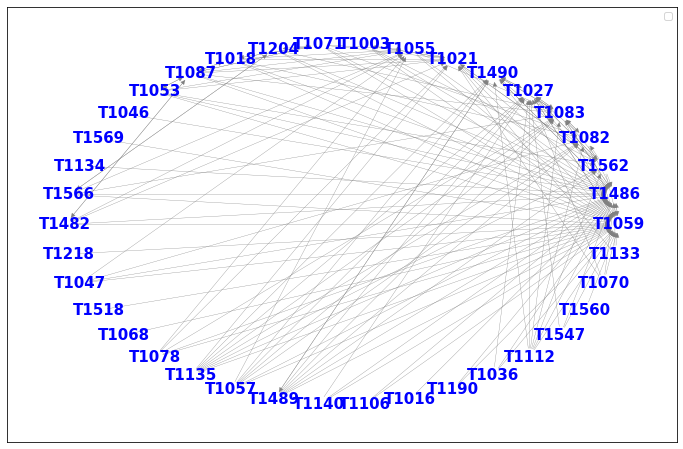

In [36]:
cocDiGraph : nx.DiGraph =  generateDiGraph2(cocTTPs, techniques, tactics)

In [37]:
def getAdjacencyMatrix(cocDiGraph, techniques):
    print('*** printing the adjacency matrix ***')
    # print(dod)
    nodelists = list(cocDiGraph.nodes())

    Index = nodelists
    Columns = nodelists

    IndexWithTTPsObject = []
    for idx in Index:
        te = next((x for x in techniques if x.id == idx), None)
        IndexWithTTPsObject.append(te)

    IndexWithTTPsObject.sort(key = lambda v : v.id)
    IndexWithTTPsObject.sort(key = lambda v : v.tactics[0].sequence)
    Index = [f'{x.id}' for x in IndexWithTTPsObject]
    Columns = [f'{x.id}' for x in IndexWithTTPsObject]

    df = pd.DataFrame(index=Index, columns=Columns)

    for ix in Index:
        for cl in Columns:
            if cocDiGraph.has_edge(ix, cl):
                df.at[ix, cl] = '√'
            else:
                df.at[ix, cl] = ' '

    print(tb.tabulate(df, headers='keys', showindex=True, tablefmt='psql'))

In [38]:
getAdjacencyMatrix(cocDiGraph, techniques)

*** printing the adjacency matrix ***
+-------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|       | T1133   | T1190   | T1566   | T1047   | T1053   | T1059   | T1106   | T1204   | T1569   | T1547   | T1068   | T1027   | T1036   | T1055   | T1070   | T1078   | T1112   | T1134   | T1140   | T1218   | T1562   | T1003   | T1016   | T1018   | T1046   | T1057   | T1082   | T1083   | T1087   | T1135   | T1482   | T1518   | T1021   | T1560   | T1071   | T1486   | T1489   | T1490   |
|-------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---